# EhV

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from pandas.api.types import CategoricalDtype
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import numpy

## Data import

In [4]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [5]:
df = pq.read_table(data_dir / f"results/scip/202201311209_skitty/features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df[numpy.load(data_dir / "results/scip/202201311209_skitty/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "results/scip/202201311209_skitty/index.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
label_cat_type = CategoricalDtype(categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df["meta_label"] = df["meta_label"].astype(label_cat_type)
df.shape

(102979, 921)

In [6]:
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_group", "meta_suffix"])

In [39]:
df.loc["Inf"].reset_index().to_feather(data_dir / f"results/scip/202201311209_skitty/features.feather", compression="uncompressed")

In [8]:
selected = df.filter(regex="feat").columns

## Feature correlation

In [ ]:
df = df.drop(columns=df.filter(regex='euler').columns)

In [ ]:
%%time
correlation = df.sample(n=50000).filter(regex="feat.*").corr()

In [ ]:
correlation.isna().sum().sum()

In [ ]:
seaborn.clustermap(correlation)

### Pairwise correlated feature removal

In [ ]:
def get_correlated_features(df, cutoff=0.9):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [ ]:
correlated_features = get_correlated_features(
    df.filter(regex="feat").drop(columns=df.filter(regex='euler').columns),
    cutoff=0.9
)

In [ ]:
correlation2 = df.filter(regex="feat").drop(columns=df.filter(regex='euler').columns).drop(columns=correlated_features).corr()

In [ ]:
seaborn.clustermap(correlation2)

In [ ]:
len(correlated_features)

In [ ]:
df = df.drop(columns=correlated_features)

In [ ]:
df.shape

In [ ]:
df.filter(regex="feat")

### Clustering features

In [ ]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cut_tree

In [ ]:
z = fastcluster.linkage(correlation, method="ward")

In [ ]:
_ = dendrogram(z, truncate_mode="lastp", p=100)

In [ ]:
membership = cut_tree(z, n_clusters=100)[:, 0]

In [ ]:
selected = []
for i, gdf in df.filter(regex="feat").T.groupby(membership):
    col = correlation[gdf.index].abs().mean(axis=0).idxmin()
    selected.append(col)

In [ ]:
corr2 = df[selected].corr()

In [ ]:
seaborn.clustermap(corr2)

# Dimensionality reduction

In [9]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.preprocessing import scale, robust_scale
import umap
from sklearn.model_selection import train_test_split

### Control + infected

In [ ]:
pca = PCA().fit_transform(scale(df[selected].fillna(0)))

In [ ]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none")

In [ ]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_type"], s=1, alpha=0.5, edgecolors="none")

In [ ]:
pca = PCA(n_components=0.95).fit_transform(scale(df[selected].fillna(0)))

In [ ]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection = model.fit_transform(pca)

In [ ]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

In [ ]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df["meta_group"], 
    hue_order=df["meta_group"].cat.categories,
    s=1, alpha=0.5, edgecolors="none", ax=ax)

In [ ]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df["meta_type"],
    s=1, alpha=0.5, edgecolors="none", ax=ax)

### Infected only

In [10]:
idx = df.loc["Inf"][df.loc["Inf"]["meta_label"] == "mcp-_psba+"].index

In [27]:
df2 = df.loc["Inf"]
df2 = df2.drop(index=idx[:9000])

N = 5000
df2 = df2.sample(n=N)

#### PCA

In [28]:
%%time
pca = PCA(n_components=0.95).fit_transform(robust_scale(df2[selected].fillna(0)))

CPU times: user 3.06 s, sys: 1.98 s, total: 5.04 s
Wall time: 791 ms


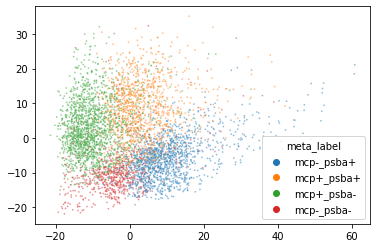

In [29]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df2["meta_label"], s=3, alpha=0.5, edgecolors="none")

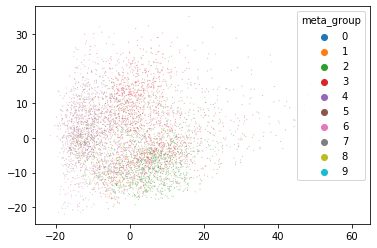

In [30]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df2.index.get_level_values("meta_group"), s=1, alpha=0.5, edgecolors="none")

In [31]:
%%time
k_pca = KernelPCA(n_components=None, random_state=0, eigen_solver="randomized", n_jobs=10).fit_transform(scale(df2[selected].fillna(0)))

CPU times: user 9min 10s, sys: 2min 48s, total: 11min 58s
Wall time: 1min 23s


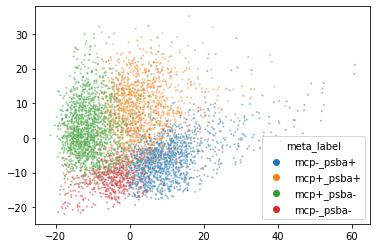

In [32]:
seaborn.scatterplot(x=k_pca[:, 0], y=k_pca[:, 1], hue=df2["meta_label"], s=4, alpha=0.5, edgecolors="none")

In [40]:
from sklearn.manifold import MDS

In [44]:
mds_model = MDS(n_components=2, random_state=0, n_jobs=10)

In [45]:
%%time
mds = mds_model.fit_transform(scale(df2[selected].fillna(0)))

CPU times: user 1.18 s, sys: 1.76 s, total: 2.94 s
Wall time: 3min 23s


#### UMAP

In [34]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection_pca = model.fit_transform(pca)

CPU times: user 25.7 s, sys: 737 ms, total: 26.4 s
Wall time: 24 s


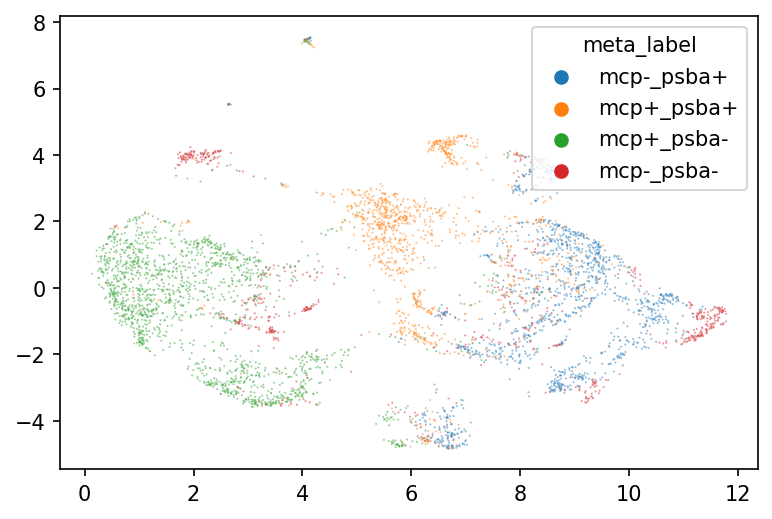

In [36]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection_pca[:, 0], y=projection_pca[:, 1], hue=df2["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

In [37]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection_kpca = model.fit_transform(k_pca)

CPU times: user 14.9 s, sys: 781 ms, total: 15.6 s
Wall time: 13.3 s


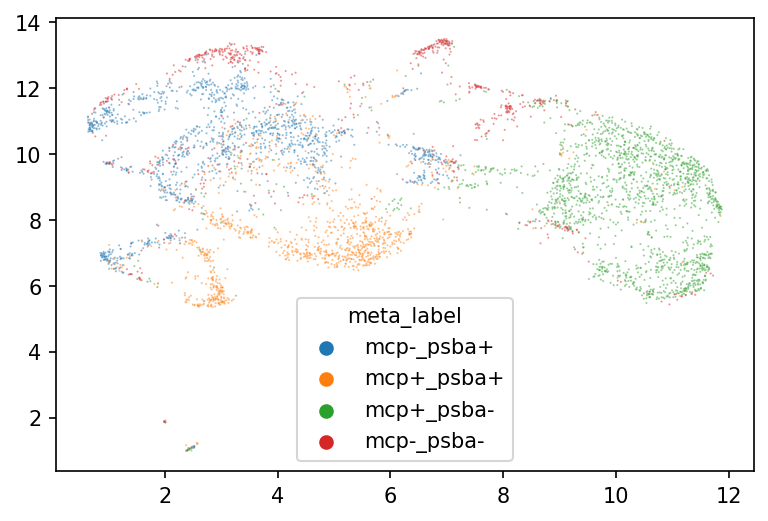

In [38]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection_kpca[:, 0], y=projection_kpca[:, 1], hue=df2["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

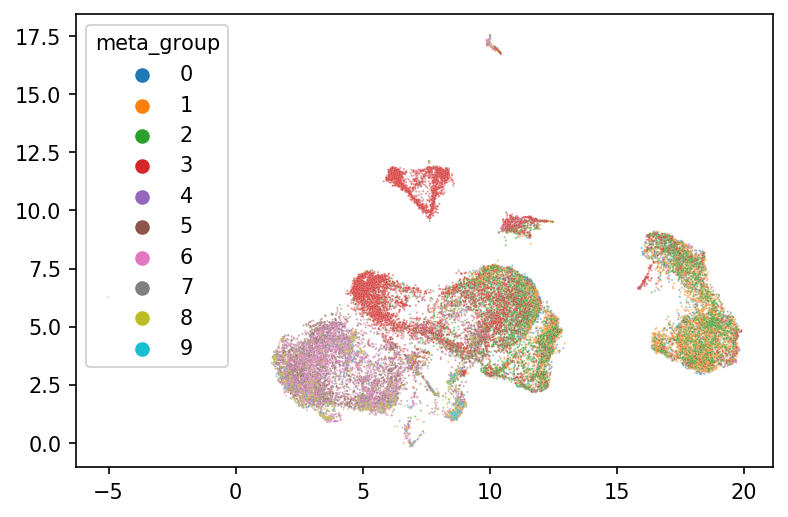

In [35]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df.loc["Inf"].index.get_level_values("meta_group"), 
    hue_order=df.loc["Inf"].index.get_level_values("meta_group").categories,
    s=1, alpha=0.5, edgecolors="none", ax=ax)

In [41]:
gmm = GaussianMixture(n_components=8)

In [42]:
%%time
gmm.fit(pca)

CPU times: user 50.5 s, sys: 1min 9s, total: 2min
Wall time: 16.1 s


GaussianMixture(n_components=8)

In [43]:
df["meta_cluster"] = None
df.loc["Inf", "meta_cluster"] = gmm.predict(pca)
df["meta_cluster"] = df["meta_cluster"].astype("category")

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2914: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


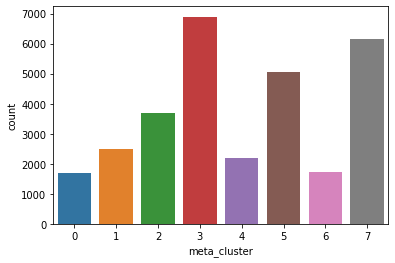

In [44]:
seaborn.countplot(data=df, x="meta_cluster")

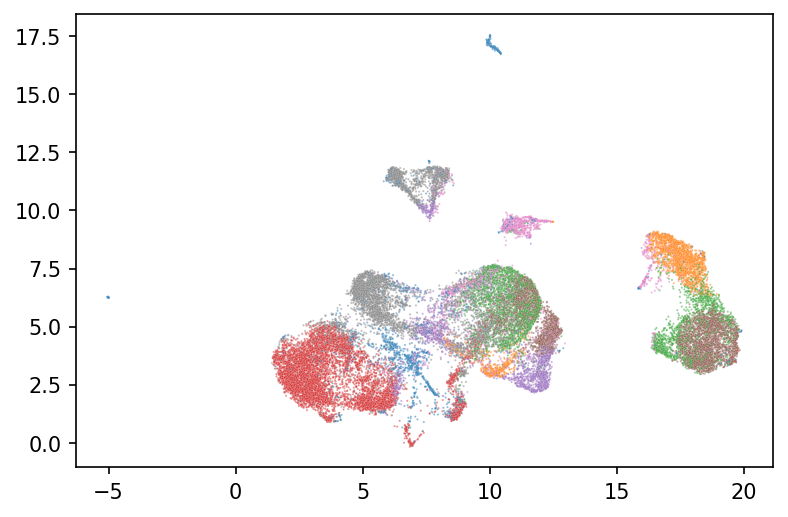

In [46]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df.loc["Inf"]["meta_cluster"], s=1, alpha=0.5, edgecolors="none", ax=ax, legend=False)

In [48]:
from sklearn.neighbors import NearestNeighbors

In [93]:
nbrs = NearestNeighbors(n_neighbors=2, radius=10, n_jobs=10, metric="cosine").fit(pca)

In [94]:
%%time
dist, index = nbrs.kneighbors(pca, n_neighbors=2, return_distance=True)

CPU times: user 21.8 s, sys: 24 s, total: 45.7 s
Wall time: 13.1 s


In [95]:
from kneed import KneeLocator
kneedle = KneeLocator(numpy.arange(dist.shape[0]), sorted(dist[:, -1]), S=1.0, curve="convex", direction="increasing")

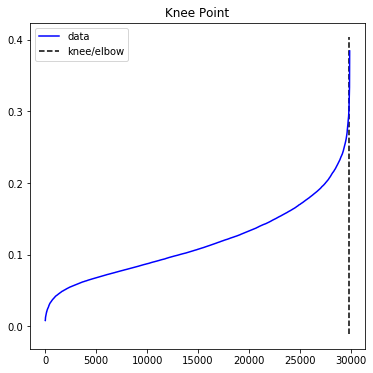

In [96]:
kneedle.plot_knee()

In [97]:
eps = numpy.sort(dist[:, -1])[kneedle.elbow]

In [102]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric="cosine")

In [103]:
%%time
df["meta_cluster"] = None
df.loc["Inf", "meta_cluster"] = dbscan.fit_predict(pca)
df["meta_cluster"] = df["meta_cluster"].astype("category")

CPU times: user 9.11 s, sys: 14.9 s, total: 24 s
Wall time: 4.44 s


/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


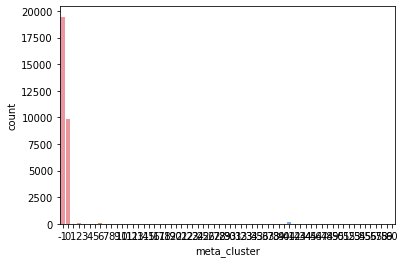

In [104]:
seaborn.countplot(data=df, x="meta_cluster")

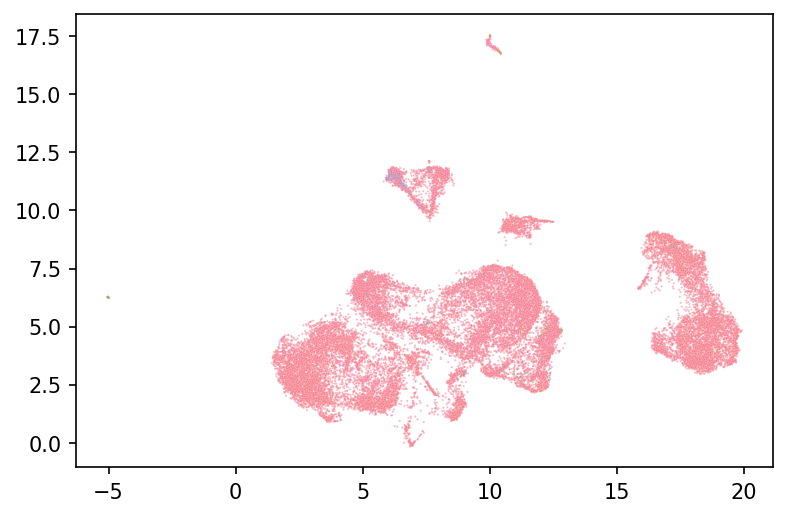

In [105]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df.loc["Inf"]["meta_cluster"], s=1, alpha=0.5, edgecolors="none", ax=ax, legend=False)

In [38]:
slingshot_df = pandas.DataFrame(
    data=numpy.hstack([projection, pca, df.loc["Inf"][["meta_cluster"]]]),
    columns=["umap_0",  "umap_1"] + [f"pca_{i}" for i in range(pca.shape[1])] + ["cluster"]
)

In [39]:
slingshot_df.to_feather(data_dir / f"results/scip/202201311209_skitty/slingshot_pca0.75.feather", compression="uncompressed")

In [28]:
df["meta_slingshot_pt"] = None
df.loc["Inf", "meta_slingshot_pt"] = feather.read_feather('/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/pt.feather').values.flatten()

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2914: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


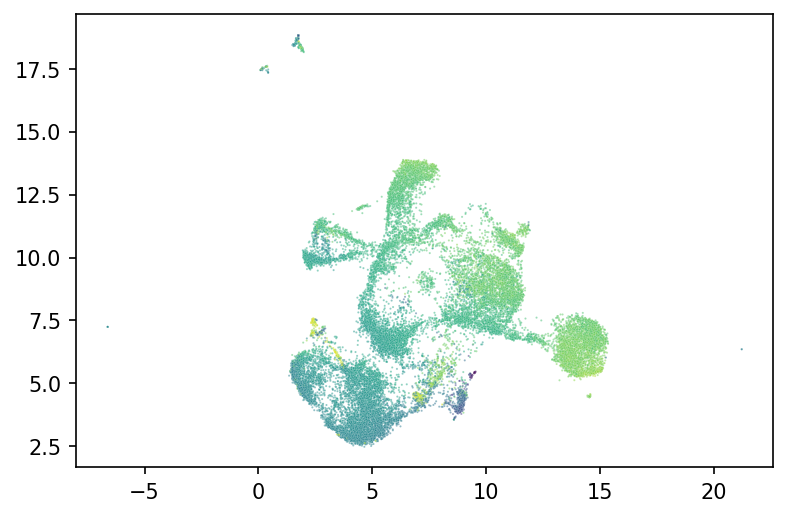

In [29]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df.loc["Inf"]["meta_slingshot_pt"], 
    palette="viridis",
    s=1, alpha=0.5, edgecolors="none", 
    ax=ax, legend=False)